In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from datetime import datetime


from utils import concat_dfs, substituir_cod_municipio


In [2]:
data_type = "files"  # files ou api

auxilio_emergencial = concat_dfs(
    f"parsed_data/auxilio_emergencial/{data_type}"
)

bolsa_familia = concat_dfs(f"parsed_data/bolsa_familia/{data_type}")

suicidios = pd.read_csv("parsed_data/suicidios/suicidios.csv")
suicidios["date"] = pd.to_datetime(suicidios["date"])
suicidios["municipio_ibge"] = suicidios["municipio_ibge"].astype(float)

populacao = pd.read_csv("parsed_data/municipios/populacao.csv")

internacoes = pd.read_csv("parsed_data/internacoes/internacoes.csv")
internacoes["date"] = pd.to_datetime(internacoes["date"])
internacoes["municipio_ibge6"] = internacoes["municipio_ibge6"].astype(float)


In [3]:
bolsa_familia = substituir_cod_municipio(bolsa_familia)


In [4]:
auxilio_emergencial = auxilio_emergencial[
    auxilio_emergencial["municipio_ibge"].notna()
]
auxilio_emergencial["municipio_ibge"] = auxilio_emergencial[
    "municipio_ibge"
].astype(int)
suicidios["municipio_ibge"] = suicidios["municipio_ibge"].astype(int)
internacoes["municipio_ibge6"] = internacoes["municipio_ibge6"].astype(int)


In [5]:
df_all = pd.merge(
    bolsa_familia,
    auxilio_emergencial,
    on=["municipio_ibge", "date"],
    how="outer",
)


In [6]:
df_all = pd.merge(
    df_all, suicidios, on=["municipio_ibge", "date"], how="outer"
)


In [7]:
df_all["year"] = df_all["date"].dt.year


In [8]:
def remove_last_digit(x):
    if len(str(x)) == 7:
        return int(str(x)[:-1])
    else:
        return int(str(x))


df_all["municipio_ibge6"] = df_all["municipio_ibge"].apply(
    lambda x: remove_last_digit(x)
)


In [9]:
df_all = pd.merge(
    df_all, populacao, on=["municipio_ibge6", "year"], how="outer"
)


In [10]:
df_all = pd.merge(
    df_all, internacoes, on=["municipio_ibge6", "date"], how="outer"
)


In [11]:
df_all = df_all[df_all["municipio_ibge"] != 0]


In [12]:
df_all['internacao_jovens'] = df_all['Menor 1 ano'] + df_all['1 a 4 anos'] + df_all['5 a 9 anos'] + df_all['10 a 14 anos'] + df_all['15 a 19 anos'] + df_all['20 a 24 anos'] + df_all['25 a 29 anos']

In [13]:
# ordering columns
columns = [
    "municipio_ibge",
    "contagem_x",
    # "soma_x",
    "date",
    # "soma_y",
    "contagem_y",
    # "suicidios",
    # "obitos_totais",
    # "taxa_suicidio",
    "year",
    "municipio_ibge6",
    "populacao",
    "nome",
    "total_internacoes_psico",
    "total_internacoes_geral",
    "internacao_jovens",
]
df_all = df_all[columns]


In [14]:
df_all.columns = [
    "municipio_ibge",
    "beneficiarios_bolsa_familia",
    # "valor_bolsa_familia",
    "date",
    # "valor_auxilio_emergencial",
    "beneficiarios_auxilio_emergencial",
    # "suicidios",
    # "obitos_totais",
    # "taxa_suicidio",
    "ano",
    "municipio_ibge6",
    "populacao",
    "nome_municipio",
    "total_internacoes_psico",
    "total_internacoes_geral",
    "internacao_jovens",
]


In [15]:
date_mask = (df_all["date"] >= "2019-08") & (df_all["date"] <= "2020-12")
df_all = df_all[date_mask]


In [16]:
df_all["beneficiarios_bolsa_familia"] = df_all[
    "beneficiarios_bolsa_familia"
].fillna(0)
df_all["beneficiarios_auxilio_emergencial"] = df_all[
    "beneficiarios_auxilio_emergencial"
].fillna(0)


In [17]:
# Dropando municipios sem dados de populacao (37 linhas)
df_all.dropna(subset="populacao", inplace=True)


In [18]:
# preenchendo dados faltantes de obitos e suicidios (assume-se que são 0 nessas datas)
# df_all["obitos_totais"].fillna(0, inplace=True)
# df_all["suicidios"].fillna(0, inplace=True)
# df_all["taxa_suicidio"].fillna(0, inplace=True)


In [19]:
df_all.isna().sum()


municipio_ibge                       0
beneficiarios_bolsa_familia          0
date                                 0
beneficiarios_auxilio_emergencial    0
ano                                  0
municipio_ibge6                      0
populacao                            0
nome_municipio                       0
total_internacoes_psico              0
total_internacoes_geral              0
internacao_jovens                    0
dtype: int64

In [20]:
# # Não usado
# df_all["valor_bolsa_familia"] = df_all["valor_bolsa_familia"].fillna(0)
# df_all["valor_auxilio_emergencial"] = df_all[
#     "valor_auxilio_emergencial"
# ].fillna(0)
# df_all["valor_total"] = (
#     df_all["valor_bolsa_familia"] + df_all["valor_auxilio_emergencial"]
# )

# df_all["valor_medio"] = df_all["valor_total"] / (
#     df_all["beneficiarios_auxilio_emergencial"]
#     + df_all["beneficiarios_bolsa_familia"]
# )


In [21]:
df_all["cobertura_ae"] = (
    df_all["beneficiarios_auxilio_emergencial"] / df_all["populacao"]
)
df_all["cobertura_bf"] = (
    df_all["beneficiarios_bolsa_familia"] / df_all["populacao"]
)


In [22]:
df_all['taxa_internacoes'] = df_all['total_internacoes_psico'] / df_all['total_internacoes_geral']
df_all['taxa_internacoes_jovens'] = df_all['internacao_jovens'] / df_all['total_internacoes_geral']

In [23]:
df_all['internacoes_por_100'] = (df_all['total_internacoes_psico'] * 100) / df_all['populacao']
df_all['internacoes_jovens_por_100'] = (df_all['internacao_jovens'] * 100) / df_all['populacao']

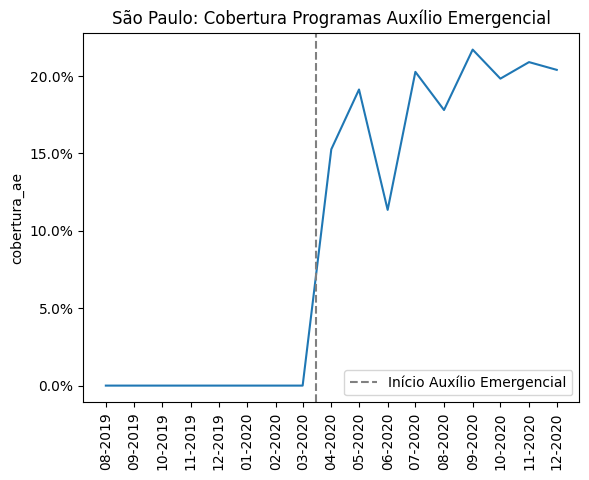

In [24]:
data = df_all[df_all["municipio_ibge"] == 3550308]
ax = sns.lineplot(data=data, x="date", y="cobertura_ae")
ax.set(xticks=data.date.values)
ax.xaxis.set_major_formatter(dates.DateFormatter("%m-%Y"))
ax.yaxis.set_major_formatter(lambda x, y: "{:1.1f}%".format(x * 100))
# plt.yticks(np.arange(0, max(data["valor_total"]), 250_000_000))
plt.xticks(rotation=90)
# plt.ylabel("Soma Benefícios (R$)")
plt.xlabel("")
plt.axvline(
    datetime(2020, 3, 15),
    linestyle="dashed",
    label="Início Auxílio Emergencial",
    color="grey",
)
plt.title("São Paulo: Cobertura Programas Auxílio Emergencial")
plt.legend()
plt.show()


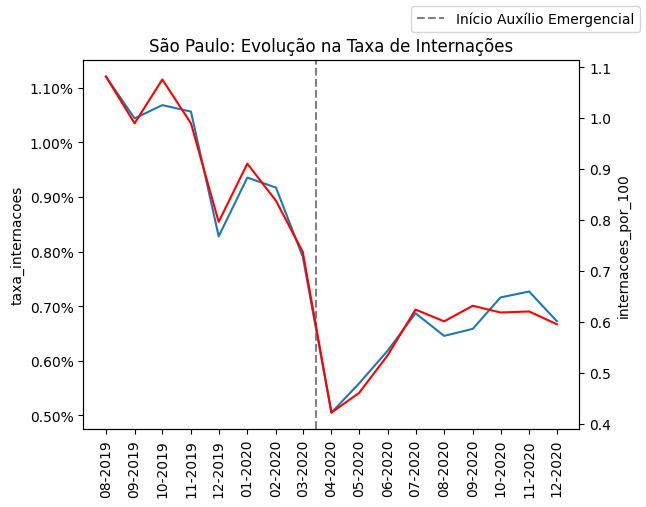

In [183]:
data = df_all[df_all["municipio_ibge"] == 3550308]
ax = sns.lineplot(data=data, x="date", y="taxa_internacoes", legend=False)
ax.set(xticks=data.date.values)
ax.xaxis.set_major_formatter(dates.DateFormatter("%m-%Y"))
ax.yaxis.set_major_formatter(lambda x, y: "{:,.2f}%".format(x * 100))
plt.xticks(rotation=90)
plt.xlabel("")
plt.axvline(
    datetime(2020, 3, 15),
    linestyle="dashed",
    label="Início Auxílio Emergencial",
    color="grey",
)
ax2 = ax.twinx()
sns.lineplot(data=data, x="date", y="internacoes_por_100", ax=ax2, legend=False, color = 'red')
plt.title("São Paulo: Evolução na Taxa de Internações")
ax.figure.legend()
plt.show()


Agregando os municípios e vendo quebra dos que tiveram maior grau de cobertura

2020-03-01 00:00:00
2020-04-01 00:00:00


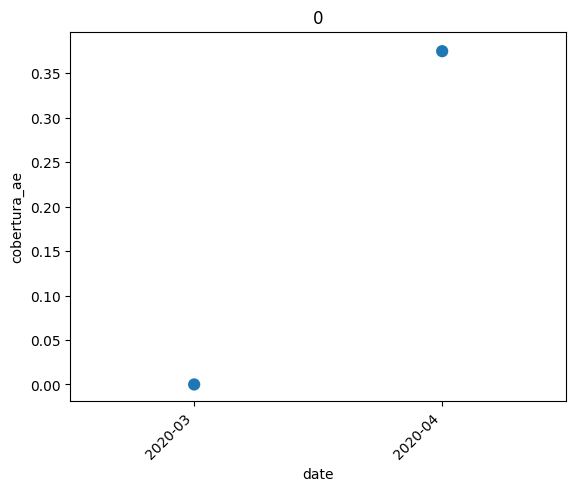

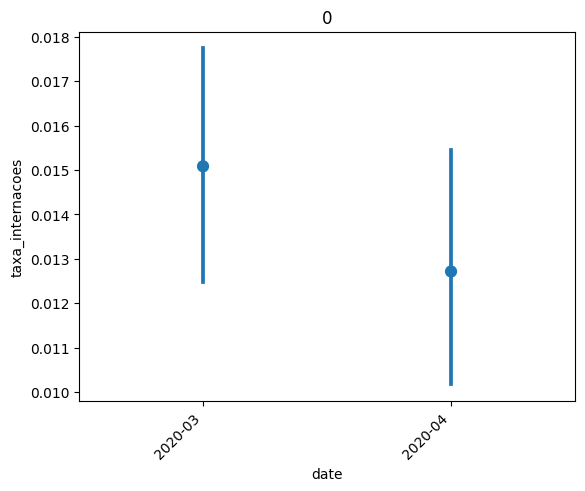

2020-02-01 00:00:00
2020-05-01 00:00:00


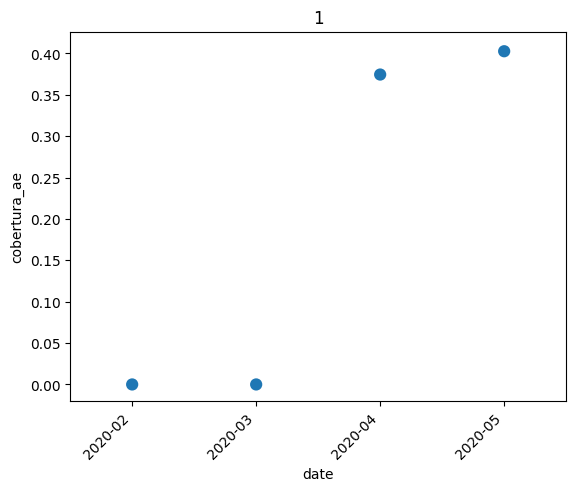

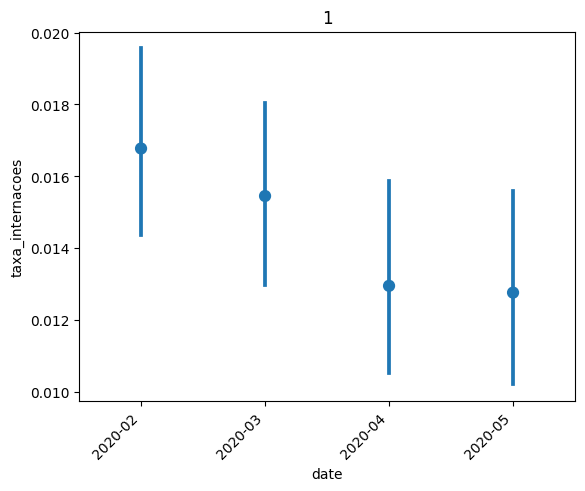

2019-12-01 00:00:00
2020-07-01 00:00:00


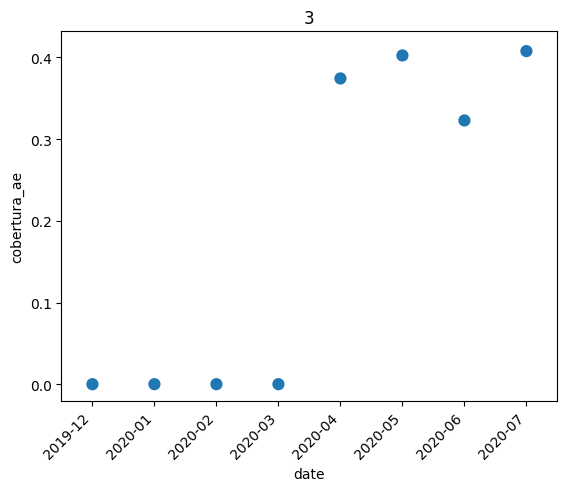

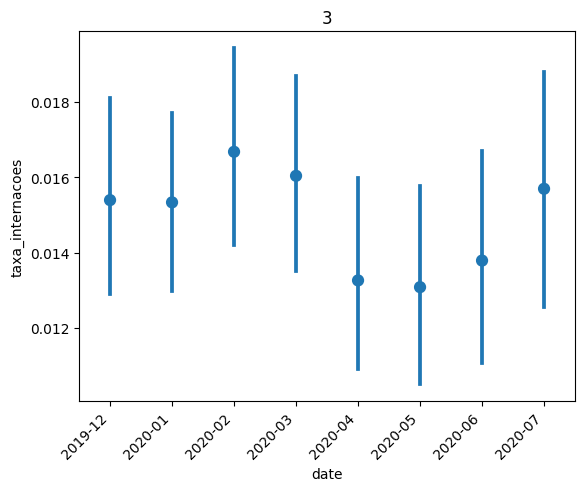

2019-09-01 00:00:00
2020-10-01 00:00:00


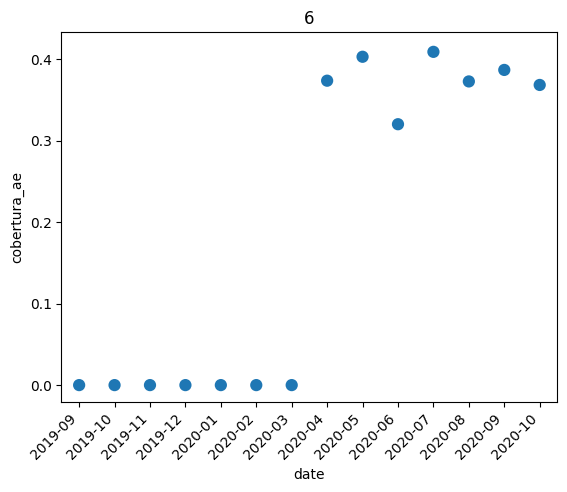

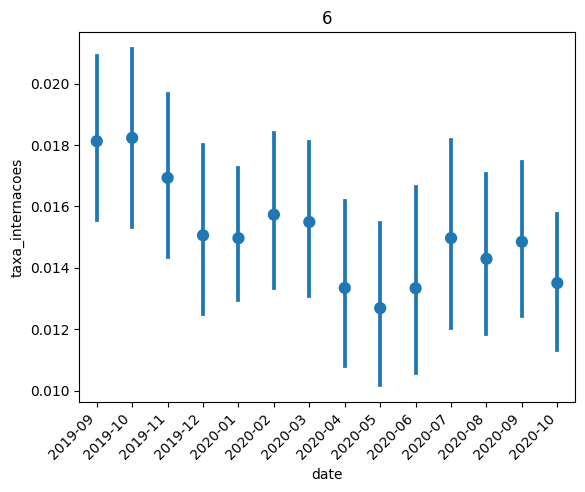

2019-07-01 00:00:00
2020-12-01 00:00:00


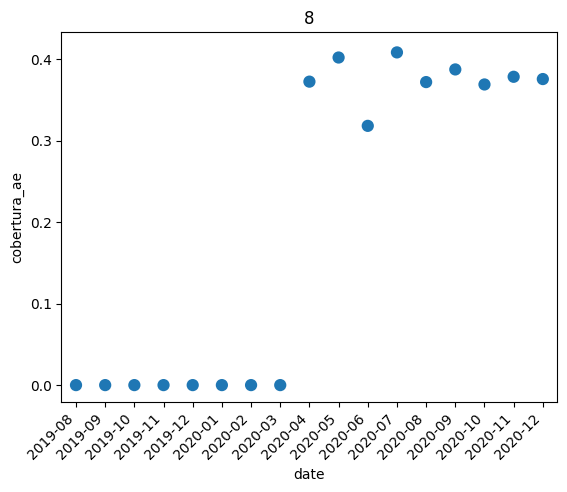

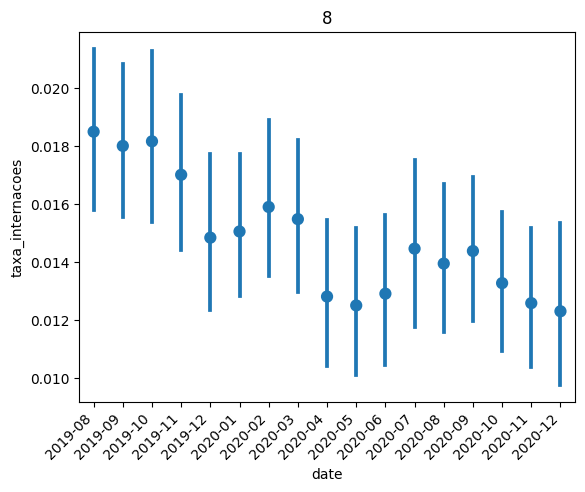

In [54]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    print(start_date)
    print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "cobertura_ae", "taxa_internacoes"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = (
        df_antes_depois["cobertura_ae_y"] - df_antes_depois["cobertura_ae_x"]
    )

    divisao = 5
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    maior_percentil = df_antes_depois[
        df_antes_depois["percentil"] == df_antes_depois["percentil"].max()
    ]["municipio_ibge"].unique()

    time_series_data = df_all[df_all["municipio_ibge"].isin(maior_percentil)]

    date_filter = (time_series_data["date"] >= start_date) & (
        time_series_data["date"] <= end_date
    )

    time_series_data = time_series_data[date_filter]

    ax = sns.pointplot(
        data=time_series_data,
        x="date",
        y="cobertura_ae",
        join=False,
        orient="v",
        order=np.sort(time_series_data["date"].unique()),
    )
    x_dates = (
        time_series_data["date"].dt.strftime("%Y-%m").sort_values().unique()
    )
    ax.set_xticklabels(labels=x_dates, rotation=45, ha="right")
    plt.title(f"{n_meses}")
    plt.show()

    ax = sns.pointplot(
        data=time_series_data,
        x="date",
        y="taxa_internacoes",
        join=False,
        orient="v",
        order=np.sort(time_series_data["date"].unique()),
    )
    x_dates = (
        time_series_data["date"].dt.strftime("%Y-%m").sort_values().unique()
    )
    ax.set_xticklabels(labels=x_dates, rotation=45, ha="right")
    plt.title(f"{n_meses}")
    plt.show()


Agregando os municípios e vendo quebra dos que tiveram menor grau de cobertura

2020-03-01 00:00:00
2020-04-01 00:00:00


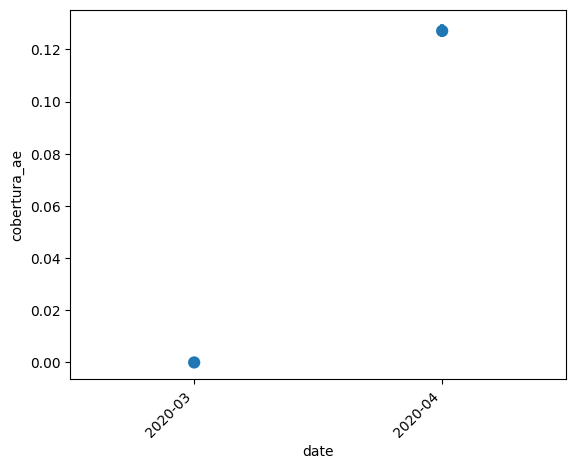

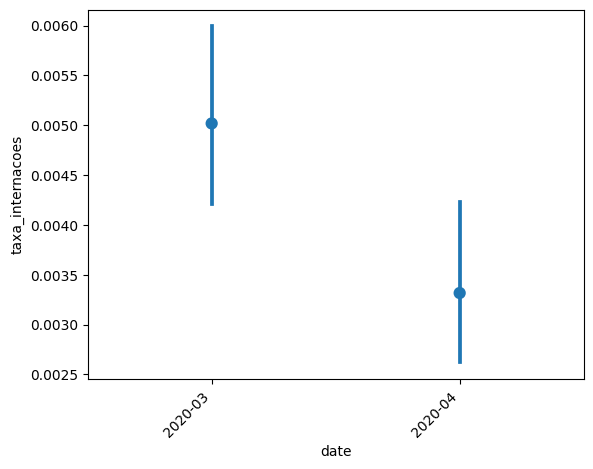

2020-02-01 00:00:00
2020-05-01 00:00:00


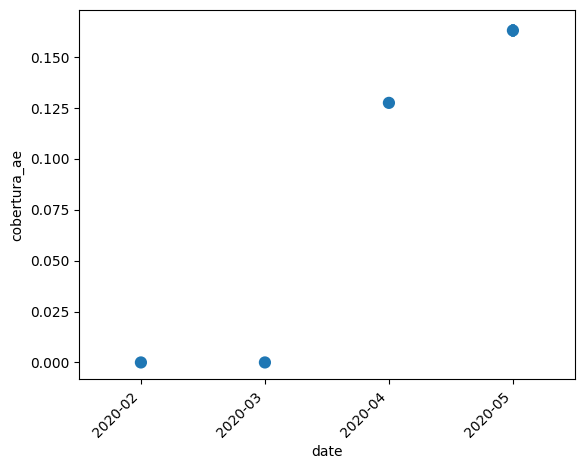

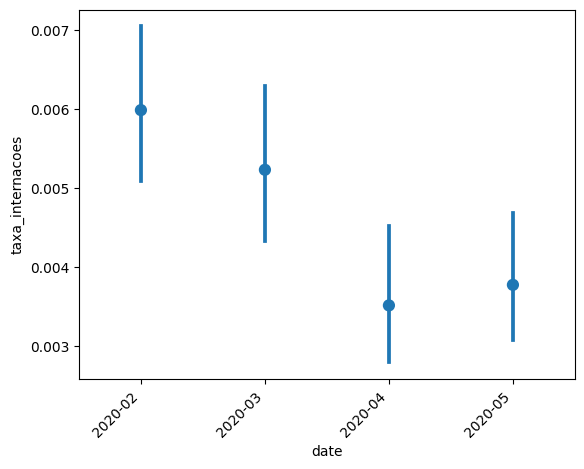

2019-12-01 00:00:00
2020-07-01 00:00:00


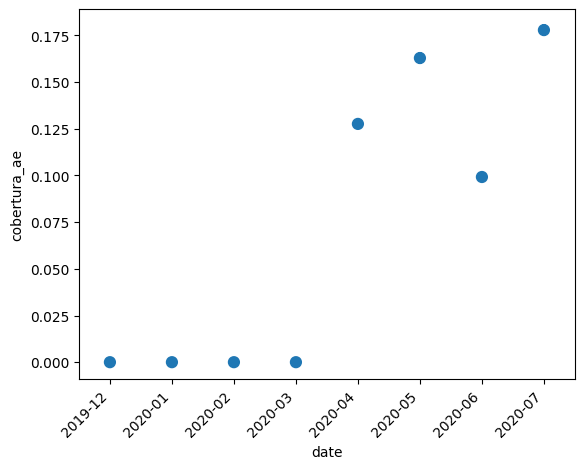

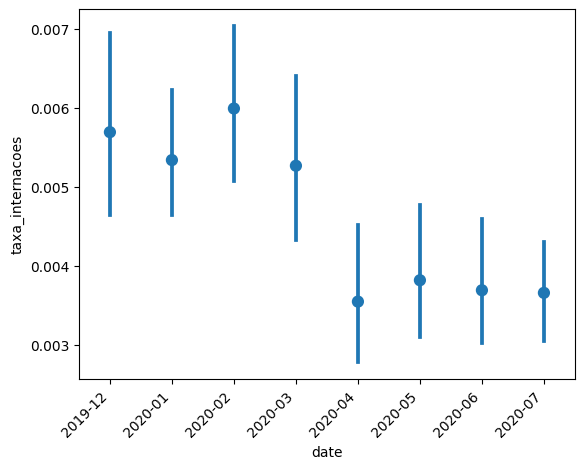

2019-09-01 00:00:00
2020-10-01 00:00:00


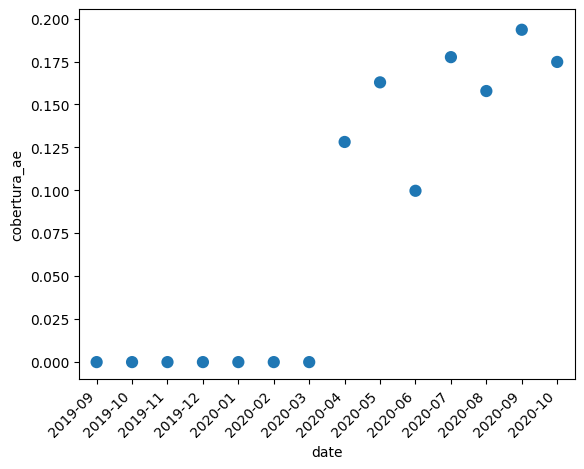

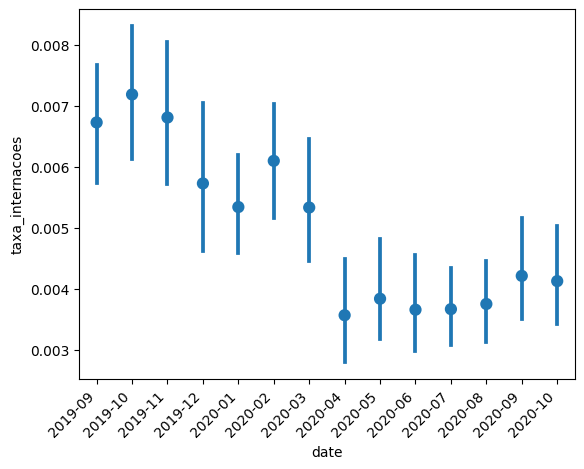

2019-07-01 00:00:00
2020-12-01 00:00:00


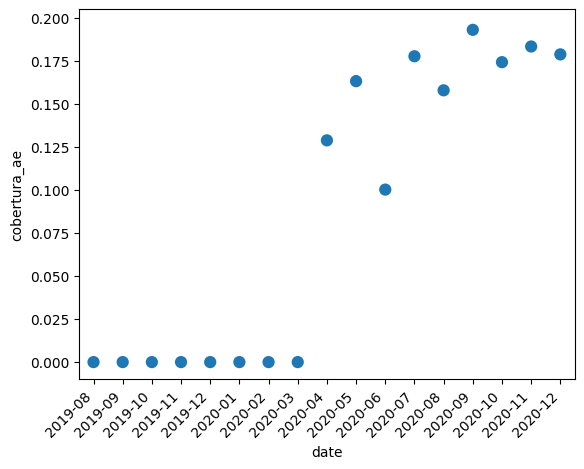

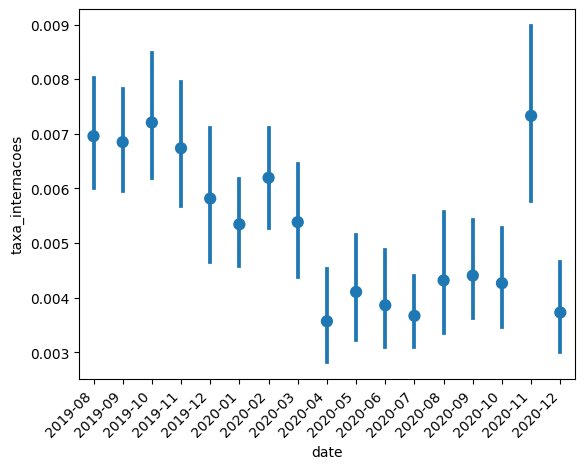

In [56]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    print(start_date)
    print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "cobertura_ae", "taxa_internacoes"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = (
        df_antes_depois["cobertura_ae_y"] - df_antes_depois["cobertura_ae_x"]
    )

    divisao = 5
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    menor_percentil = df_antes_depois[
        df_antes_depois["percentil"] == df_antes_depois["percentil"].min()
    ]["municipio_ibge"].unique()

    time_series_data = df_all[df_all["municipio_ibge"].isin(menor_percentil)]

    date_filter = (time_series_data["date"] >= start_date) & (
        time_series_data["date"] <= end_date
    )

    time_series_data = time_series_data[date_filter]

    ax = sns.pointplot(
        data=time_series_data,
        x="date",
        y="cobertura_ae",
        join=False,
        orient="v",
        order=np.sort(time_series_data["date"].unique()),
    )
    x_dates = (
        time_series_data["date"].dt.strftime("%Y-%m").sort_values().unique()
    )
    ax.set_xticklabels(labels=x_dates, rotation=45, ha="right")
    plt.show()

    ax = sns.pointplot(
        data=time_series_data,
        x="date",
        y="taxa_internacoes",
        join=False,
        orient="v",
        order=np.sort(time_series_data["date"].unique()),
    )
    x_dates = (
        time_series_data["date"].dt.strftime("%Y-%m").sort_values().unique()
    )
    ax.set_xticklabels(labels=x_dates, rotation=45, ha="right")
    plt.show()


## Grau de cobertura


taxa de internacoes

2020-03-01 00:00:00
2020-04-01 00:00:00
-0.00112340854692358
-0.002236343483201368
-0.001734725990167627
-0.002606818293162042
-0.0015047992279757392
-0.0017693258996231915
-0.003512399339909147
0.0006922032961857397
-0.0027910858771379252
-0.004783660766068867
-0.0023479233432674683
-0.0034276861448092107
-0.0028328975365327757
-0.003194611977683023
-0.0010859686800152746


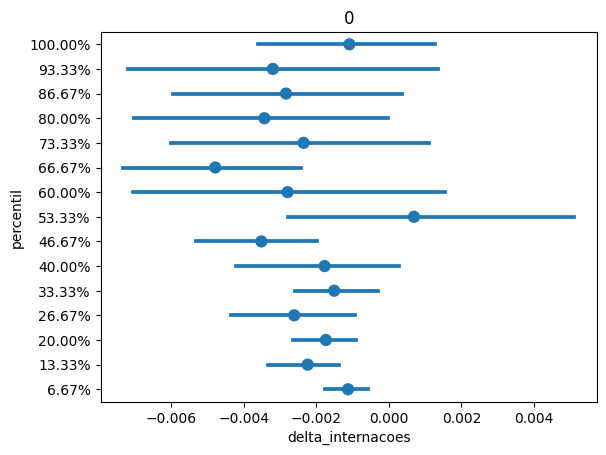

2020-02-01 00:00:00
2020-05-01 00:00:00
-0.0010098097957410164
-0.0020178286901045886
-0.002889647132083572
-0.0030623980803033074
-0.0011009725031993671
-0.0022628081386151834
-0.004401825878660847
-0.0012870505238995016
-0.004332062664876507
-0.002971817217851771
-0.0034923703865671757
-0.0018475282021513627
-0.005618353508509671
-0.0037969776053440405
-0.0003366488885004834


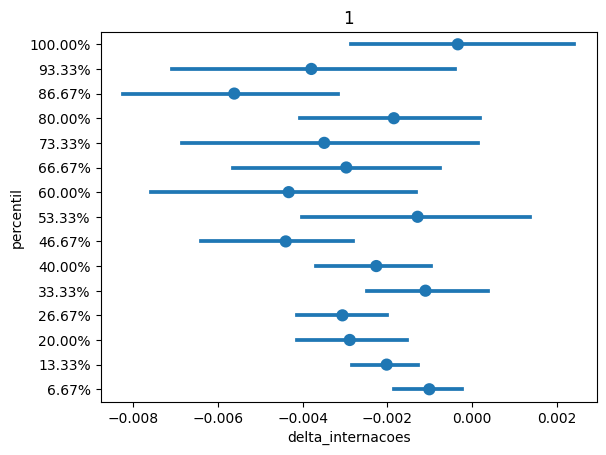

2019-12-01 00:00:00
2020-07-01 00:00:00
-0.0008691100322499733
-0.002361829077352421
-0.00244575307104252
-0.003037157970677543
-0.0018649736388014083
-0.002492622660145818
-0.0037898543170621565
-0.00158106598976189
-0.003871924520749071
-0.001359994402000221
-0.002927024317277163
-0.0004819048188690698
-0.0023908168183795243
-0.003138162561259981
-0.00014116732424442752


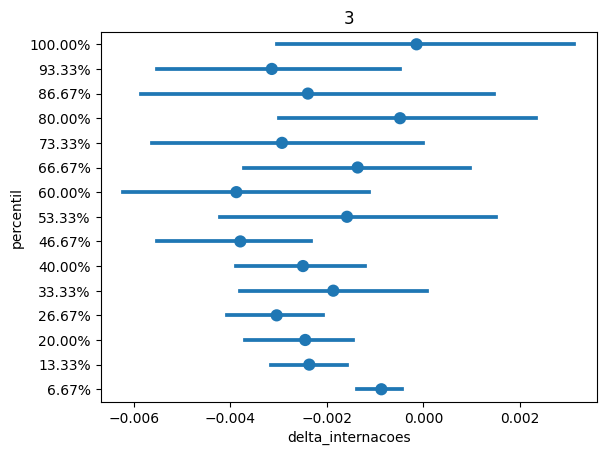

2019-09-01 00:00:00
2020-10-01 00:00:00
-0.0012186673596898665
-0.0027211119452966977
-0.003123956212696893
-0.0024484587681228055
-0.0038854955114844296
-0.0030865164668509018
-0.0027861233913251664
-0.004399912516208023
-0.0051861802042016385
-0.0017656250627799928
-0.0036365160529455154
-0.003993488095121726
-0.003320000402863073
-0.0030448879071748296
-0.0011616768231105298


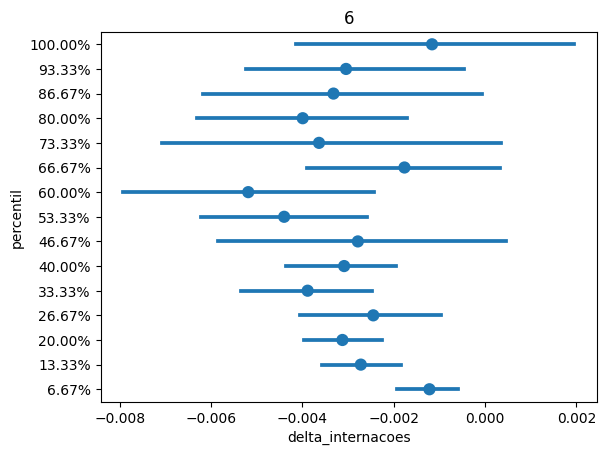

2019-07-01 00:00:00
2020-12-01 00:00:00
-0.0008931940837882089
-0.002631262300746863
-0.0023478759363690684
-0.0029980646509518384
-0.004133712589996771
-0.003411849731331875
-0.004074557459625219
-0.005671547697564139
-0.0044732455111351245
-0.0031919875880850983
-0.004112949045035834
-0.00421917865204496
-0.00521102936624394
-0.002952989326217778
-0.0019813216373408098


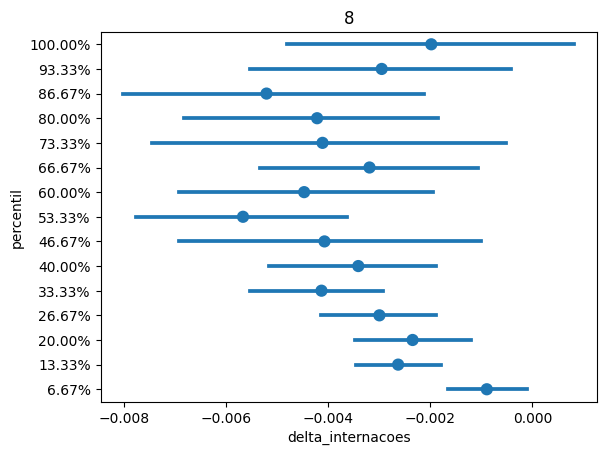

In [89]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    print(start_date)
    print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "cobertura_ae", "taxa_internacoes"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = df_antes_depois["cobertura_ae_y"] - 0

    divisao = 15
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    df_antes_depois["delta_internacoes"] = (
        df_antes_depois["taxa_internacoes_y"] - df_antes_depois["taxa_internacoes_x"]
    )

    for i, df_percentil in enumerate(df_divisions):
        print(
            df_percentil["taxa_internacoes_y"].mean()
            - df_percentil["taxa_internacoes_x"].mean()
        )
        pass

    ax = sns.pointplot(
        data=df_antes_depois,
        x="delta_internacoes",
        y="percentil",
        join=False,
        orient="h",
        order=-np.sort(-df_antes_depois["percentil"].unique()),
    )
    y_value = [
        "{:,.2f}".format(x * 100) + "%"
        for x in -np.sort(-df_antes_depois["percentil"].unique())
    ]
    ax.set_yticklabels(y_value)
    plt.title(n_meses)
    plt.show()


taxa internacoes jovens

2020-03-01 00:00:00
2020-04-01 00:00:00
-0.00025873642210699007
-0.0004589414128005224
-0.0001777889366157085
-0.0003771939371828917
-0.000364704073469738
-0.00011336030138386563
-0.0005188180715376713
0.0002590621335350901
-0.0009334791331429677
-0.0009291503765169228
-0.0006583552148279196
-0.0006863052073023965
-0.0008424604400920884
-0.000992233791183242
-0.0006085689546764849


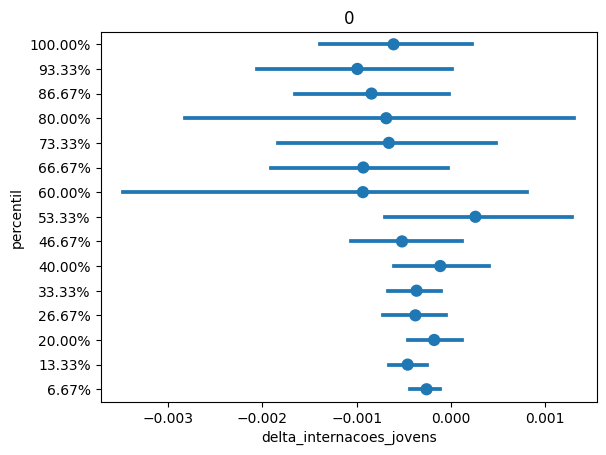

2020-02-01 00:00:00
2020-05-01 00:00:00
-0.00024189923105824953
-0.00022256902207371627
-0.0003758462321178332
-0.0005046755904196598
-0.0002206058383876382
-0.0003560413617407787
-0.00037937404427207237
-4.843111160487707e-05
-0.0016645248433453576
-0.00029339406369803794
-0.0006563252305609368
-0.0004747383733312463
-0.0013024235529721269
-0.0010115622619531399
-0.0007521707659265877


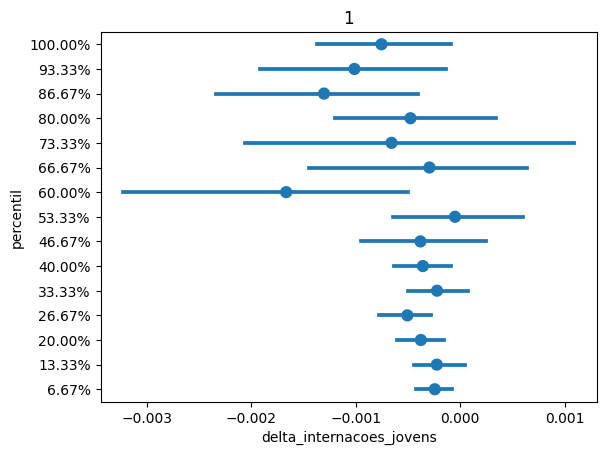

2019-12-01 00:00:00
2020-07-01 00:00:00
-0.00013933017317892596
-0.0002511409374711408
-0.0003573017672670552
-0.00042560460291523033
-0.00021009166071168602
-0.0002823344824665914
-0.0006484250404536216
-3.981400798109668e-05
-0.0010207865305950792
0.00016340587800332124
-0.0009121477314344515
0.0005232860051486215
-0.0003408521443909879
-0.0010991886410411504
-0.0005640926427782776


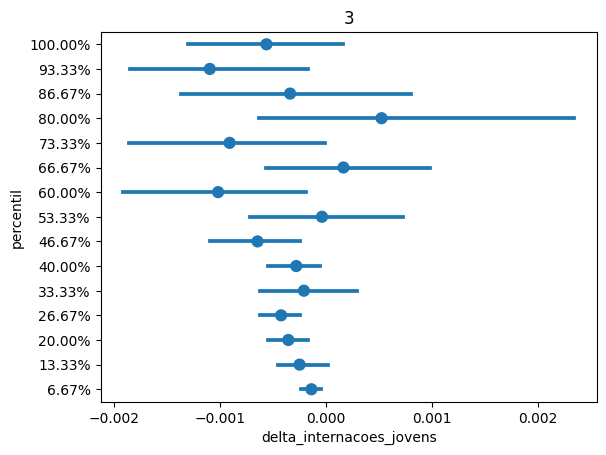

2019-09-01 00:00:00
2020-10-01 00:00:00
-0.0002139785396465116
-0.0004484374245834178
-0.0005524295112543335
-0.0004614932633846447
-0.0005365099490966974
-0.00047358359317540254
-0.00020479607630475736
-0.0009094482686578488
-0.001159080731321639
-0.00028528707087514555
-0.0005921261656195
-0.000644349291178856
-0.0009185265969398129
-0.0008033883625683889
-0.0006459205005773187


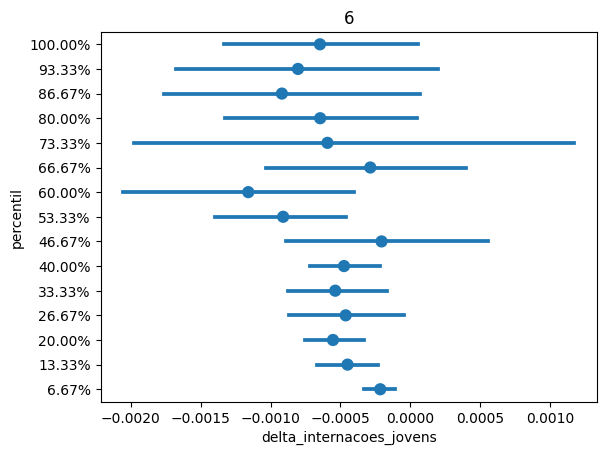

2019-07-01 00:00:00
2020-12-01 00:00:00
-0.00014618874176803903
-0.0004771123662922062
-0.00045898674119232517
-0.0005808430742555281
-0.0005805423902811684
-0.000604990149314481
-0.0005692297483917549
-0.0011809116865735153
-0.000877387495518443
-0.0004963002995696259
-0.0007783492688258334
-0.0008201568976547455
-0.0013509750514064203
-0.0007309202779091171
-0.0008262861782925191


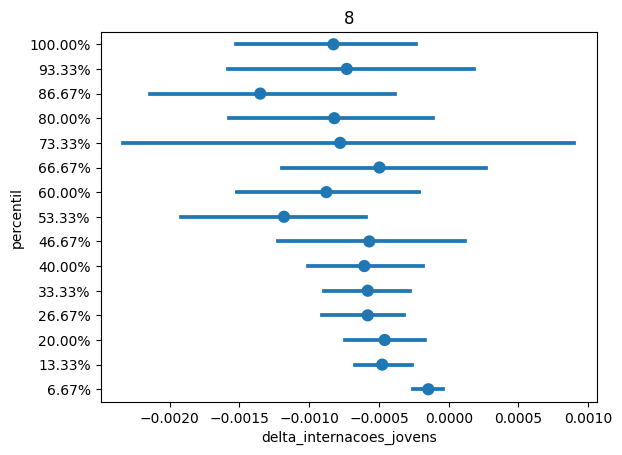

In [90]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    print(start_date)
    print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "cobertura_ae", "taxa_internacoes_jovens"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = df_antes_depois["cobertura_ae_y"] - 0

    divisao = 15
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    df_antes_depois["delta_internacoes_jovens"] = (
        df_antes_depois["taxa_internacoes_jovens_y"] - df_antes_depois["taxa_internacoes_jovens_x"]
    )

    for i, df_percentil in enumerate(df_divisions):
        print(
            df_percentil["taxa_internacoes_jovens_y"].mean()
            - df_percentil["taxa_internacoes_jovens_x"].mean()
        )
        pass

    ax = sns.pointplot(
        data=df_antes_depois,
        x="delta_internacoes_jovens",
        y="percentil",
        join=False,
        orient="h",
        order=-np.sort(-df_antes_depois["percentil"].unique()),
    )
    y_value = [
        "{:,.2f}".format(x * 100) + "%"
        for x in -np.sort(-df_antes_depois["percentil"].unique())
    ]
    ax.set_yticklabels(y_value)
    plt.title(n_meses)
    plt.show()


internacoes por 100

2020-03-01 00:00:00
2020-04-01 00:00:00
-0.11534000114357915
-0.18305770284479628
-0.16549986375623765
-0.18117649106059577
-0.1199982157806235
-0.20730333940326656
-0.22697464106618512
-0.04968207480554418
-0.13360383611124838
-0.16774232004786493
-0.22760477423605152
-0.1754660701258595
-0.1302976128481672
-0.163254824195019
-0.0849208054112674


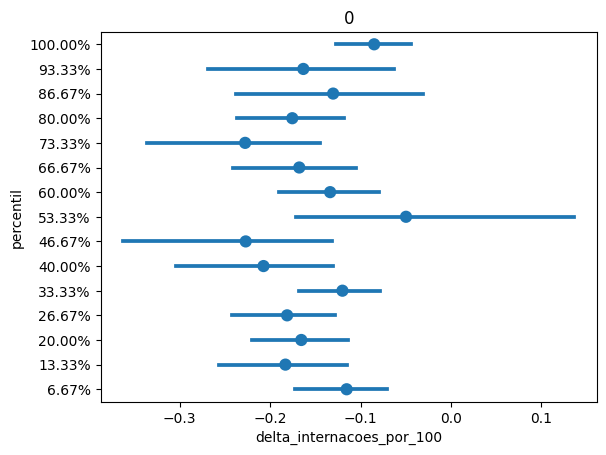

2020-02-01 00:00:00
2020-05-01 00:00:00
-0.10567713097891082
-0.19003523649182447
-0.21936698549599457
-0.1900587171550595
-0.13844654609388346
-0.1776982517089634
-0.26939939501107435
-0.13787786737012034
-0.15517893626087823
-0.16357697287412276
-0.26942209395700895
-0.1459096857079002
-0.2145675813754366
-0.17430269398224432
-0.06017196960400634


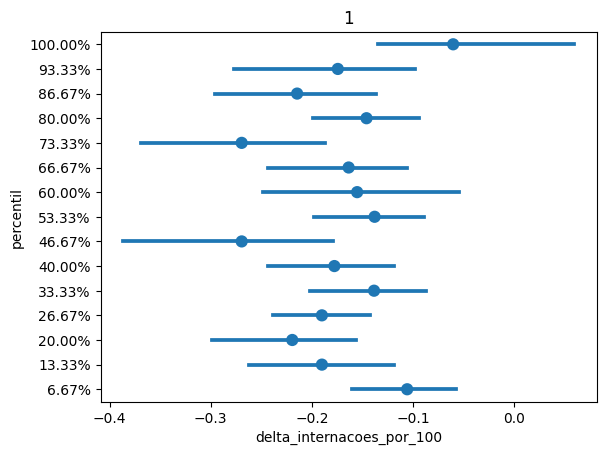

2019-12-01 00:00:00
2020-07-01 00:00:00
-0.07872134824905405
-0.21231039355495002
-0.17406683984492444
-0.18992533192560812
-0.1493378645099819
-0.16276964368847827
-0.2358542810854188
-0.1469817703070919
-0.1488916789105102
-0.08499125569858851
-0.23095469138773622
-0.1262078034820068
-0.1709751799747291
-0.18441354144791236
-0.059789435041902456


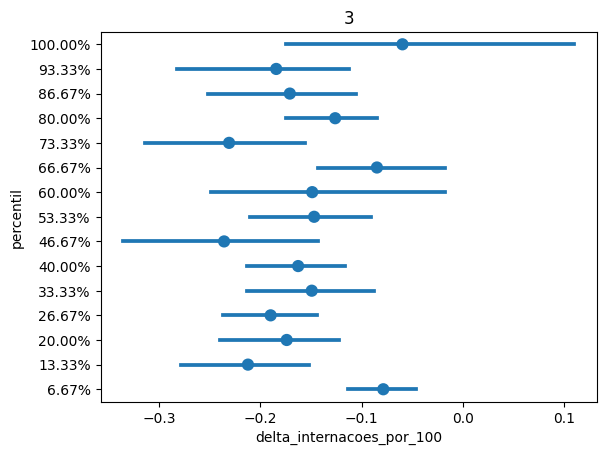

2019-09-01 00:00:00
2020-10-01 00:00:00
-0.09597728667832767
-0.2766829111863765
-0.20768951556194315
-0.16921406419349708
-0.2165547198111882
-0.1824448759826119
-0.25192845037680917
-0.15843343352548706
-0.14038777651933243
-0.12892923912211057
-0.2269836923390964
-0.20947044632914114
-0.18606242778732557
-0.1858714395871613
-0.09672299962217695


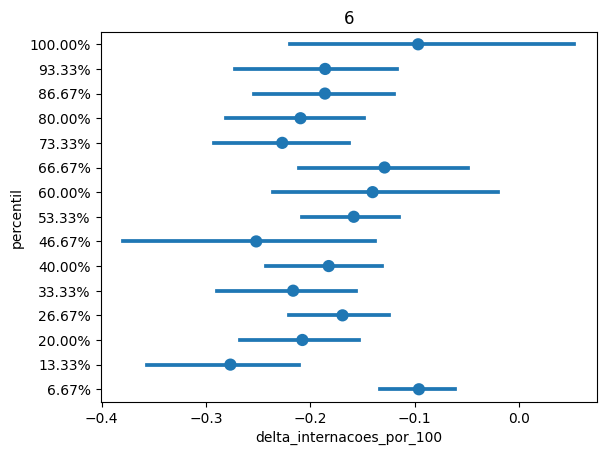

2019-07-01 00:00:00
2020-12-01 00:00:00
-0.09778675450495997
-0.2911445711192068
-0.19747218007921208
-0.1756799469413663
-0.22006770177855095
-0.18783789946227042
-0.28071084452671824
-0.1760152114619885
-0.12810743504644467
-0.16802967345827535
-0.2123804400804676
-0.21024033122544905
-0.23146572184060699
-0.18978667233788155
-0.10427213445582123


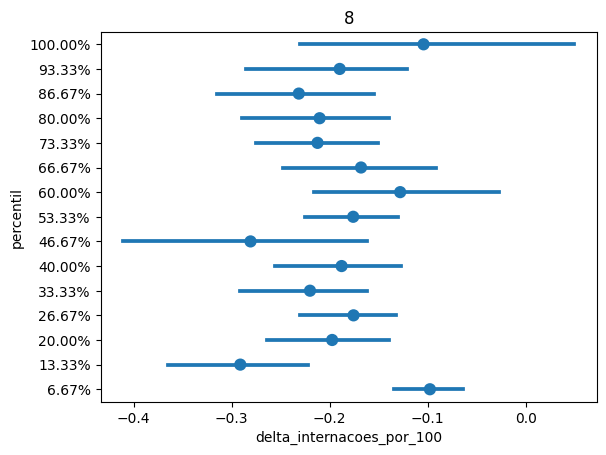

In [101]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    print(start_date)
    print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "cobertura_ae", "internacoes_por_100"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = df_antes_depois["cobertura_ae_y"] - 0

    divisao = 15
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    df_antes_depois["delta_internacoes_por_100"] = (
        df_antes_depois["internacoes_por_100_y"] - df_antes_depois["internacoes_por_100_x"]
    )

    for i, df_percentil in enumerate(df_divisions):
        print(
            df_percentil["internacoes_por_100_y"].mean()
            - df_percentil["internacoes_por_100_x"].mean()
        )
        pass

    ax = sns.pointplot(
        data=df_antes_depois,
        x="delta_internacoes_por_100",
        y="percentil",
        join=False,
        orient="h",
        order=-np.sort(-df_antes_depois["percentil"].unique()),
    )
    y_value = [
        "{:,.2f}".format(x * 100) + "%"
        for x in -np.sort(-df_antes_depois["percentil"].unique())
    ]
    ax.set_yticklabels(y_value)
    plt.title(n_meses)
    plt.show()


internacoes por 100

2020-03-01 00:00:00
2020-04-01 00:00:00
-0.02296083171874995
-0.03850894065002539
-0.027726036824999287
-0.03401465365668685
-0.02292397634178435
-0.029708869983178794
-0.046407108305265815
-0.010110705958856409
-0.038648559077354545
-0.04359107486682243
-0.05953820930493409
-0.04948302188331385
-0.042243790524213995
-0.043683042890163004
-0.03419960294563678


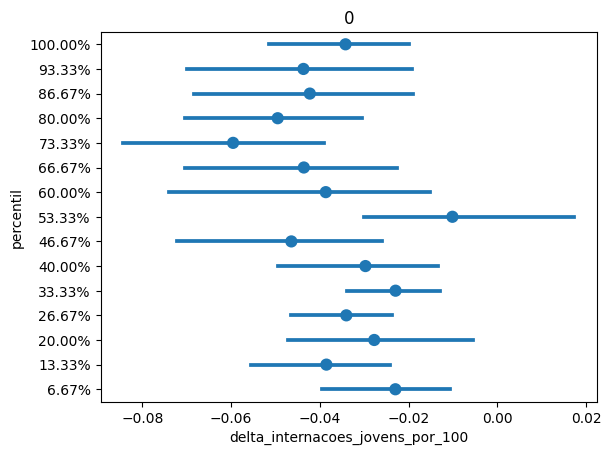

2020-02-01 00:00:00
2020-05-01 00:00:00
-0.021053199113866182
-0.023421236682588137
-0.03615803022306978
-0.031163671497040794
-0.025797127739955822
-0.027936010264085494
-0.03608849840779152
-0.019482520863969108
-0.04892661462993135
-0.038679885214238485
-0.06945127335173817
-0.038724911618137264
-0.0574567297709615
-0.04729002804442413
-0.03463469229235504


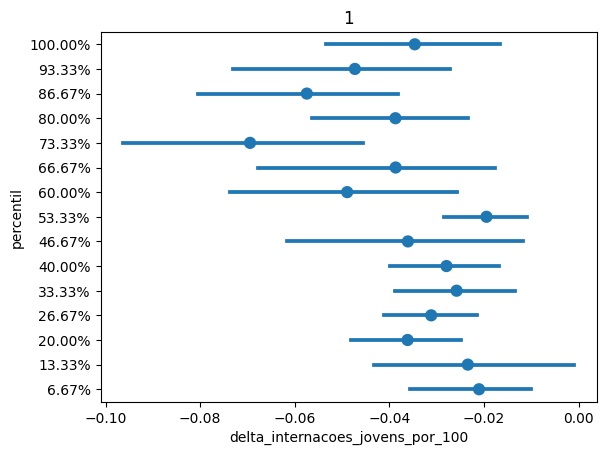

2019-12-01 00:00:00
2020-07-01 00:00:00
-0.011349490955602545
-0.0247987492786807
-0.02678882722450296
-0.029247003256179613
-0.023068078348606573
-0.02590215391541586
-0.03835749637440402
-0.018650472257307503
-0.03820340942356497
-0.01750390681775478
-0.0599092964125256
-0.03209088270276756
-0.04677965208112082
-0.05338479486938503
-0.03779179359965498


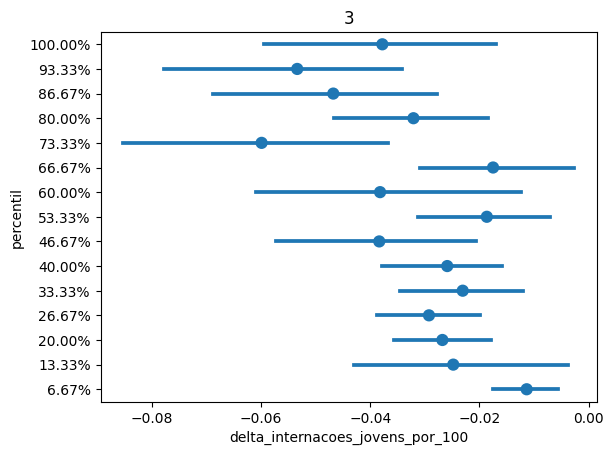

2019-09-01 00:00:00
2020-10-01 00:00:00
-0.014799219925156468
-0.04548878209308335
-0.03552926879326504
-0.028264899788873345
-0.034034133001169746
-0.030304331229063855
-0.0283033890406785
-0.033279247091365385
-0.03430262889924007
-0.028429909177243542
-0.062378525456990574
-0.04902150849768781
-0.05770657463925946
-0.05092428744925513
-0.04347693049559306


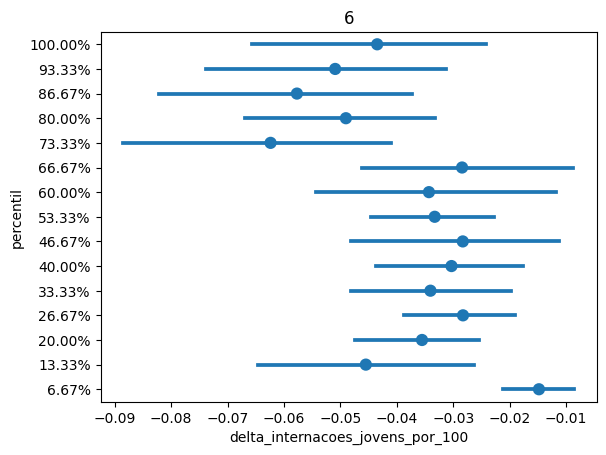

2019-07-01 00:00:00
2020-12-01 00:00:00
-0.014439373554686746
-0.049401627549374966
-0.031977836493339615
-0.02861484162489729
-0.03524327781049024
-0.03460915657566356
-0.03634059960918069
-0.03537277860876298
-0.028675477174972805
-0.03414055515256442
-0.05964612994855224
-0.05206263547462678
-0.06496954227558868
-0.0503124730348707
-0.04520982161163412


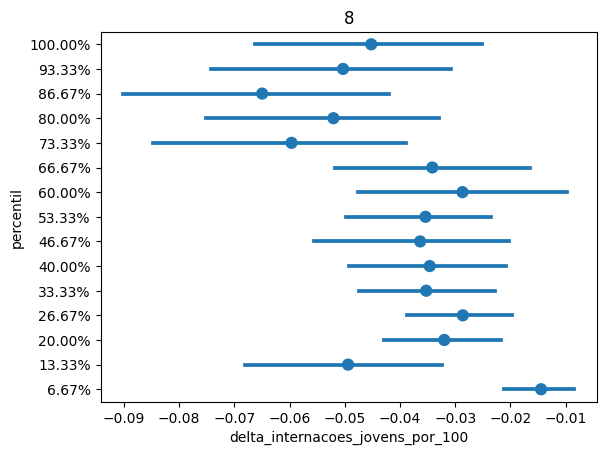

In [102]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    print(start_date)
    print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "cobertura_ae", "internacoes_jovens_por_100"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = df_antes_depois["cobertura_ae_y"] - 0

    divisao = 15
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    df_antes_depois["delta_internacoes_jovens_por_100"] = (
        df_antes_depois["internacoes_jovens_por_100_y"] - df_antes_depois["internacoes_jovens_por_100_x"]
    )

    for i, df_percentil in enumerate(df_divisions):
        print(
            df_percentil["internacoes_jovens_por_100_y"].mean()
            - df_percentil["internacoes_jovens_por_100_x"].mean()
        )
        pass

    ax = sns.pointplot(
        data=df_antes_depois,
        x="delta_internacoes_jovens_por_100",
        y="percentil",
        join=False,
        orient="h",
        order=-np.sort(-df_antes_depois["percentil"].unique()),
    )
    y_value = [
        "{:,.2f}".format(x * 100) + "%"
        for x in -np.sort(-df_antes_depois["percentil"].unique())
    ]
    ax.set_yticklabels(y_value)
    plt.title(n_meses)
    plt.show()


## Usando métrica de variação do valor médio

2020-03-01 00:00:00
2020-04-01 00:00:00
-0.003085907684265858
-0.001771286821971127
-0.002658366898623402
-0.0019567666436920775
-0.0019455020386643937


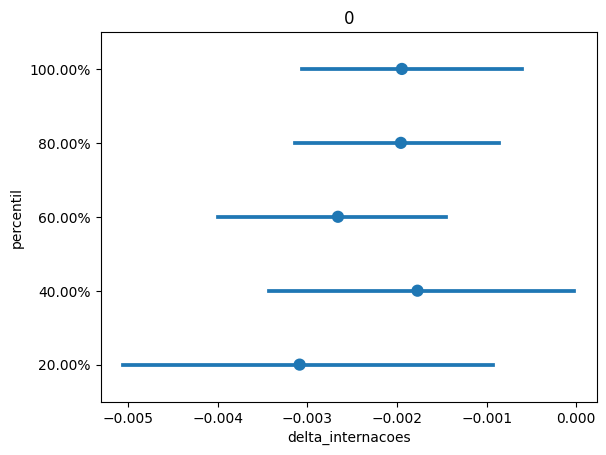

2020-02-01 00:00:00
2020-05-01 00:00:00
-0.002088318939492677
-0.0035287147091507525
-0.0028189836260764656
-0.0027954232536693147
-0.0022415446291412632


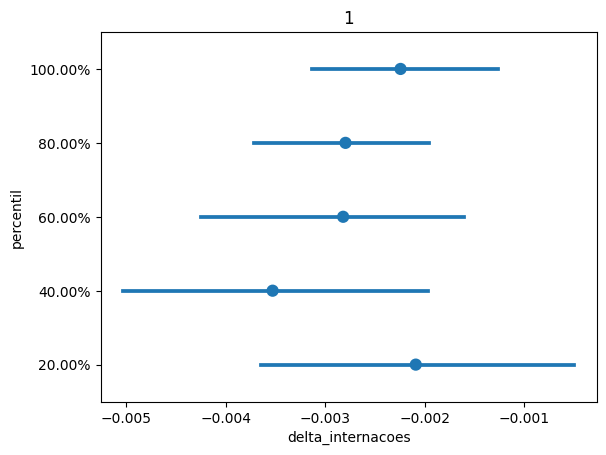

2019-12-01 00:00:00
2020-07-01 00:00:00
-0.0005663928003373508
-0.0027072475304239715
-0.002087985743511647
-0.0032267275828273337
-0.0023291292402633224


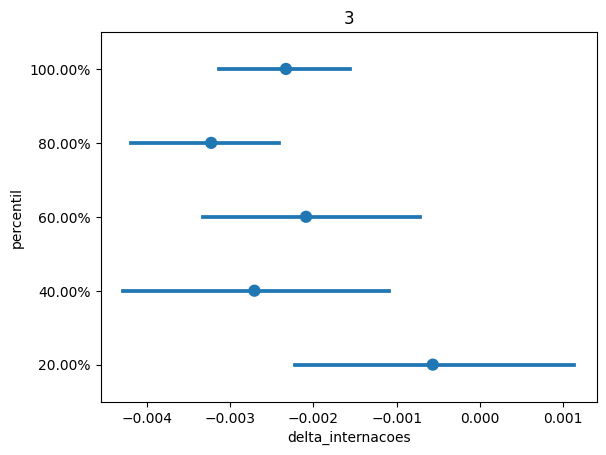

2019-09-01 00:00:00
2020-10-01 00:00:00
-0.0015076692367069315
-0.004061395734680728
-0.003546487565088118
-0.003271047257920526
-0.0028712677934581215


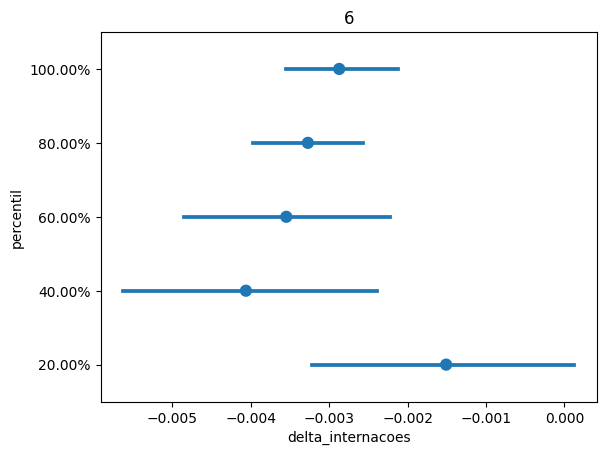

2019-07-01 00:00:00
2020-12-01 00:00:00
-0.0024240163865423114
-0.004644975218077992
-0.004333970029141442
-0.003140573901133927
-0.0028874089340765125


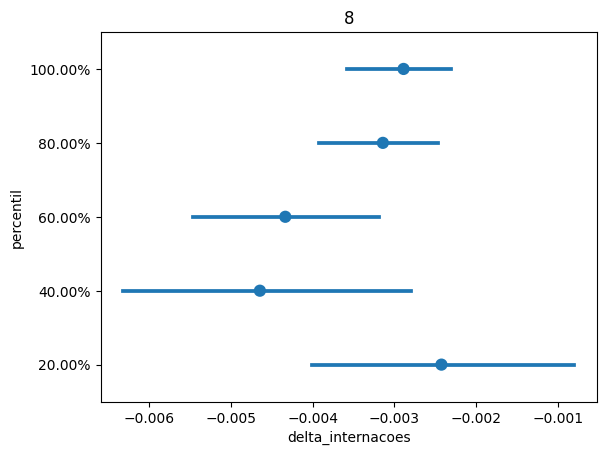

In [184]:
for n_meses in [0, 1, 3, 6, 8]:

    delta_meses = relativedelta(months=n_meses)

    mes_corte_1 = "2020-03-01"
    mes_corte_2 = "2020-04-01"

    start_date = pd.to_datetime(mes_corte_1) - delta_meses
    end_date = pd.to_datetime(mes_corte_2) + delta_meses

    print(start_date)
    print(end_date)

    df_antes = df_all[
        (df_all["date"] <= mes_corte_1) & (df_all["date"] >= start_date)
    ]
    df_depois = df_all[
        (df_all["date"] >= mes_corte_2) & (df_all["date"] <= end_date)
    ]

    colunas_relevantes = ["municipio_ibge", "valor_medio", "taxa_internacoes"]

    df_antes_mean = (
        df_antes.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )
    df_depois_mean = (
        df_depois.groupby("municipio_ibge")
        .mean()
        .reset_index()[colunas_relevantes]
    )

    df_antes_depois = pd.merge(
        df_antes_mean, df_depois_mean, on=["municipio_ibge"]
    )
    df_antes_depois["variacao"] = (
        df_antes_depois["valor_medio_y"] - df_antes_depois["valor_medio_x"]
    )

    divisao = 5
    df_divisions = np.array_split(
        df_antes_depois.sort_values("variacao"), divisao
    )
    for i, dfs_division in enumerate(df_divisions):
        indices = dfs_division.index
        df_antes_depois.loc[indices, "percentil"] = (i / divisao) + (
            1 / divisao
        )

    df_antes_depois["delta_internacoes"] = (
        df_antes_depois["taxa_internacoes_y"] - df_antes_depois["taxa_internacoes_x"]
    )

    for i, df_percentil in enumerate(df_divisions):
        print(
            df_percentil["taxa_internacoes_y"].mean()
            - df_percentil["taxa_internacoes_x"].mean()
        )
        pass

    ax = sns.pointplot(
        data=df_antes_depois,
        x="delta_internacoes",
        y="percentil",
        join=False,
        orient="h",
        order=-np.sort(-df_antes_depois["percentil"].unique()),
    )
    y_value = [
        "{:,.2f}".format(x * 100) + "%"
        for x in -np.sort(-df_antes_depois["percentil"].unique())
    ]
    ax.set_yticklabels(y_value)
    plt.title(n_meses)
    plt.show()
